# DA5401 Assignment 6 - Imputation via Regression for Missing data

### Problem Statement

We are working on a credit card risk assessment project, we are provided with a dataset which has missing values in several important feature columns. The presence of missing data prevents the immediate application of classification methods.  
We need to implement various strategies for handling this missing data and then use the resulting clean datasets to train and evaluate a classification model

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Part A : Data Preprocessing and Imputation

### Load and Prepare Data

In [2]:
df = pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df.shape

(30000, 25)

This dataset has 30000 datapoints and 25 columns, of which one is the target variable.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

We can see that, **initially, there are no null values** in the dataset.

### Artificially Introducing MAR Missing values

We choose the columns **BILL_AMT2** and **PAY_AMT5** to introduce MAR values.  
We choose the column **AGE** to be the dependency column on which the absence of data depends on.

In [5]:
cols_for_MAR = ['BILL_AMT2', 'PAY_AMT5']
dependency_col = ['AGE']

We define a function to introduce MAR.  
**MAR (Missing At Random) means that the missingness in one column depends on the values of another column** - not completely random but correlated with other features.

In [6]:
def introduce_MAR(data, columns, dependency_col):
    np.random.seed(27)
    df_mar = data.copy()

    for col in columns:
        # Create missingness probability based on dependency column
        dependency_values = df_mar[dependency_col]

        #Normalize dependency values to better compute probability values
        scaler = StandardScaler()
        dependency_scaled = scaler.fit_transform(dependency_values.values.reshape(-1, 1)).flatten()

        # Convert to probabilities (Higher absolute values ==> higher probabilities)
        missing_probs = 1 / (1 + np.exp(-dependency_scaled))  # Sigmoid function
        missing_probs = (missing_probs - missing_probs.min()) / (missing_probs.max() - missing_probs.min()) * 0.075 * 2

        mask = np.random.random(len(df_mar)) < missing_probs
        df_mar.loc[mask, col] = np.nan
        
    return df_mar
    

In [7]:
df_missing = introduce_MAR(df, cols_for_MAR, dependency_col)

### Verify number of missing values

In [8]:
df_missing[cols_for_MAR].isnull().sum()

BILL_AMT2    1704
PAY_AMT5     1672
dtype: int64

In [9]:
df_missing.isnull().any(axis=1).sum()

np.int64(3249)

We can see that, there are approximately 1700 missing values in each of the 2 columns, making a total of around 3250 rows with missing values in the entire dataset(since there will be some rows where both column values are missing).

### Divide dataset into features and target

In [10]:
X = df_missing.drop(columns = ['default.payment.next.month'])
y = df_missing['default.payment.next.month']

In [11]:
X.shape, y.shape

((30000, 24), (30000,))

## Imputation Strategy 1 : Baseline Imputation

In [12]:
df_A = df_missing.copy()

#### Replace missing values with median

In [13]:
df_A['BILL_AMT2'] = df_A['BILL_AMT2'].fillna(df_A['BILL_AMT2'].median())
df_A['PAY_AMT5'] = df_A['PAY_AMT5'].fillna(df_A['PAY_AMT5'].median())


df_A.isnull().any(axis=1).sum()

np.int64(0)

### Why is Median Imputation preferred over Mean Imputation

Mean Imputation replaces missing values with the average of available values.  
Median Imputation replaces missing values with the middle value.

Why Median imputation is preferred:  
- Median is robust to outliers whereas mean is strogly affected by outliers.
- If the features are skewed, replacing missing values with the mean will pull the distribution towards the direction of the skew.
- Median Imputation reduces bias and variance distortion but mean imputation can highly lower variance in the data

## Imputation Strategy 2 : Linear Regression

In [14]:
df_B = df_missing.copy()

We choose the column BILL_AMT2 for imputing the missing values

Divide into train and test data.  
Train data is the datapoints where BILL_AMT2 value is not null, and   
Test Data is the datapoints where BILL_AMT2 value is null.

In [15]:
df_B_train = df_B[df_B['BILL_AMT2'].notnull()]
df_B_test = df_B[df_B['BILL_AMT2'].isnull()]

In [16]:
y_B_train = df_B_train['BILL_AMT2']
X_B_train = df_B_train.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

X_B_test = df_B_test.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

In [17]:
scaler = StandardScaler()
X_B_train = scaler.fit_transform(X_B_train)
X_B_test = scaler.transform(X_B_test)

In [18]:
model = LinearRegression()

model.fit(X_B_train, y_B_train)

df_B.loc[df_B['BILL_AMT2'].isnull(), 'BILL_AMT2'] = model.predict(X_B_test)

We changed BILL_AMT2 column to be the output of linear regression, and we are changing PAY_AMT5 back to its original form.

In [19]:
df_B['PAY_AMT5'] = df['PAY_AMT5']
df_B['BILL_AMT2'].isnull().sum() , df_B['PAY_AMT5'].isnull().sum()

(np.int64(0), np.int64(0))

We can see that there are no null values remaining in the dataset.

### Underlying Assumption of Regression Imputation

The underlying assumption of Regression Imputation is that the missing values are Missing At Random (MAR). This means the likelihood of a data point being missing depends only on the values of other observed variables, not on the missing value itself.  
In such cases, the observed data contain enough information to model and predict the missing values accurately.  
For example, if BILL_AMT2 is missing more often for customers with low LIMIT_BAL, the missingness can be explained using that variable.  
Regression imputation works well under this assumption because it uses the relationships among existing variables to estimate plausible values for the missing ones.  

## Imputation Strategy 3 : Non-Linear Regression

In [20]:
df_C = df_missing.copy()

In [21]:
df_C_train = df_B[df_C['BILL_AMT2'].notnull()]
df_C_test = df_B[df_C['BILL_AMT2'].isnull()]

In [22]:
y_C_train = df_C_train['BILL_AMT2']
X_C_train = df_C_train.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

X_C_test = df_C_test.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

In [23]:
scaler = StandardScaler()
X_C_train = scaler.fit_transform(X_C_train)
X_C_test = scaler.transform(X_C_test)

In [24]:
model = DecisionTreeRegressor()

model.fit(X_C_train, y_C_train)

df_C.loc[df_C['BILL_AMT2'].isnull(), 'BILL_AMT2'] = model.predict(X_C_test)

We changed BILL_AMT2 column to be the output of Decision Tree regression, and we are changing PAY_AMT5 back to its original form.

In [25]:
df_C['PAY_AMT5'] = df['PAY_AMT5']
df_C['BILL_AMT2'].isnull().sum(), df_B['PAY_AMT5'].isnull().sum()

(np.int64(0), np.int64(0))

We can see that there are no null values remaining in the dataset.

## Part B : Model Training and Performance Assessment

### Data Split

In [26]:
X_A = df_A.drop(columns = ['default.payment.next.month'])
y_A = df_A['default.payment.next.month']
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2)

In [27]:
X_B = df_B.drop(columns = ['default.payment.next.month'])
y_B = df_B['default.payment.next.month']
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2)

In [28]:
X_C = df_C.drop(columns = ['default.payment.next.month'])
y_C = df_C['default.payment.next.month']
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2)

### 4th dataset by deleting rows with missing values

In [29]:
df_D = df_missing.dropna().copy()

In [30]:
print("Original shape:", df_missing.shape)
print("After deletion:", df_D.shape)

Original shape: (30000, 25)
After deletion: (26751, 25)


In [31]:
X_D = df_D.drop(columns = ['default.payment.next.month'])
y_D = df_D['default.payment.next.month']

X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D, test_size=0.2)

### Classifier Setup

In [32]:
def scaled_features(X_tr, X_te):
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    return X_tr_scaled, X_te_scaled

In [33]:
X_train_A_scaled , X_test_A_scaled = scaled_features(X_train_A, X_test_A)

X_train_B_scaled , X_test_B_scaled = scaled_features(X_train_B, X_test_B)

X_train_C_scaled , X_test_C_scaled = scaled_features(X_train_C, X_test_C)

X_train_D_scaled , X_test_D_scaled = scaled_features(X_train_D, X_test_D)

### Model Evaluation

In [34]:
def evaluate_Log_reg_model(X_tr, X_te, y_tr, y_te):
    model = LogisticRegression(class_weight = 'balanced', random_state = 44)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)

    return y_pred

In [35]:
print ("Classification Report for Model A:")
y_pred_A = evaluate_Log_reg_model(X_train_A_scaled, X_test_A_scaled, y_train_A, y_test_A)

classification_report_A = classification_report(y_test_A, y_pred_A)
print (classification_report_A)

Classification Report for Model A:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.63      0.47      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.71      6000



In [36]:
print ("Classification Report for Model B:")
y_pred_B = evaluate_Log_reg_model(X_train_B_scaled, X_test_B_scaled, y_train_B, y_test_B)

classification_report_B = classification_report(y_test_B, y_pred_B)
print (classification_report_B)

Classification Report for Model B:
              precision    recall  f1-score   support

           0       0.86      0.70      0.78      4650
           1       0.38      0.62      0.47      1350

    accuracy                           0.69      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.69      0.71      6000



In [37]:
print ("Classification Report for Model C:")
y_pred_C = evaluate_Log_reg_model(X_train_C_scaled, X_test_C_scaled, y_train_C, y_test_C)

classification_report_C = classification_report(y_test_C, y_pred_C)
print (classification_report_C)

Classification Report for Model C:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4709
           1       0.37      0.64      0.46      1291

    accuracy                           0.68      6000
   macro avg       0.62      0.67      0.62      6000
weighted avg       0.77      0.68      0.71      6000



In [38]:
print ("Classification Report for Model D:")
y_pred_D = evaluate_Log_reg_model(X_train_D_scaled, X_test_D_scaled, y_train_D, y_test_D)

classification_report_D = classification_report(y_test_D, y_pred_D)
print (classification_report_D)

Classification Report for Model D:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4116
           1       0.39      0.65      0.49      1235

    accuracy                           0.68      5351
   macro avg       0.63      0.67      0.63      5351
weighted avg       0.76      0.68      0.71      5351



## Part C : Comparative Analysis

### Results Comparison

In [39]:
def create_comparison_table(class_reports, model_names):
    """
    Create a comparison table from stored classification reports
    
    Parameters:
    class_reports: list of classification report dictionaries
    model_names: list of model names ['Median Imputation', 'Linear Regression Imputation', ...]
    """
    
    comparison_data = []
    
    for i, (model_name, report) in enumerate(zip(model_names, class_reports)):
        # Extract metrics for both classes
        metrics_0 = report['0']
        metrics_1 = report['1']
        accuracy = report['accuracy']
        macro_avg = report['macro avg']
        weighted_avg = report['weighted avg']
        
        model_metrics = {
            'Model': model_name,
            'Accuracy': f"{accuracy:.4f}",
            # Class 0 (Non-Default) metrics
            'Precision_0': f"{metrics_0['precision']:.4f}",
            'Recall_0': f"{metrics_0['recall']:.4f}",
            'F1_0': f"{metrics_0['f1-score']:.4f}",
            # Class 1 (Default) metrics - MOST IMPORTANT
            'Precision_1': f"{metrics_1['precision']:.4f}",
            'Recall_1': f"{metrics_1['recall']:.4f}",
            'F1_1': f"{metrics_1['f1-score']:.4f}",
            # Average metrics
            'Macro_Avg_F1': f"{macro_avg['f1-score']:.4f}",
            'Weighted_Avg_F1': f"{weighted_avg['f1-score']:.4f}",
            'Support_1': int(metrics_1['support'])  # Number of actual defaults
        }
        
        comparison_data.append(model_metrics)
    
    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    return comparison_df

In [40]:
classification_report_A = classification_report(y_test_A, y_pred_A, output_dict = True)
classification_report_B = classification_report(y_test_B, y_pred_B, output_dict = True)
classification_report_C = classification_report(y_test_C, y_pred_C, output_dict = True)
classification_report_D = classification_report(y_test_D, y_pred_D, output_dict = True)

class_reports = [classification_report_A, classification_report_B, classification_report_C, classification_report_D]
model_names = ['Median Imputation', 'Linear Regression Imputation', 'Non-Linear Regression Imputation', 'Listwise Deletion']

comparison_table = create_comparison_table(class_reports, model_names)
print("Comparison Table:")
print(comparison_table.to_string(index=False))

Comparison Table:
                           Model Accuracy Precision_0 Recall_0   F1_0 Precision_1 Recall_1   F1_1 Macro_Avg_F1 Weighted_Avg_F1  Support_1
               Median Imputation   0.6828      0.8684   0.6987 0.7743      0.3714   0.6270 0.4665       0.6204          0.7063       1327
    Linear Regression Imputation   0.6858      0.8647   0.7049 0.7767      0.3789   0.6200 0.4704       0.6235          0.7078       1350
Non-Linear Regression Imputation   0.6837      0.8751   0.6963 0.7755      0.3653   0.6375 0.4644       0.6200          0.7086       1291
               Listwise Deletion   0.6844      0.8685   0.6948 0.7720      0.3897   0.6494 0.4871       0.6296          0.7063       1235


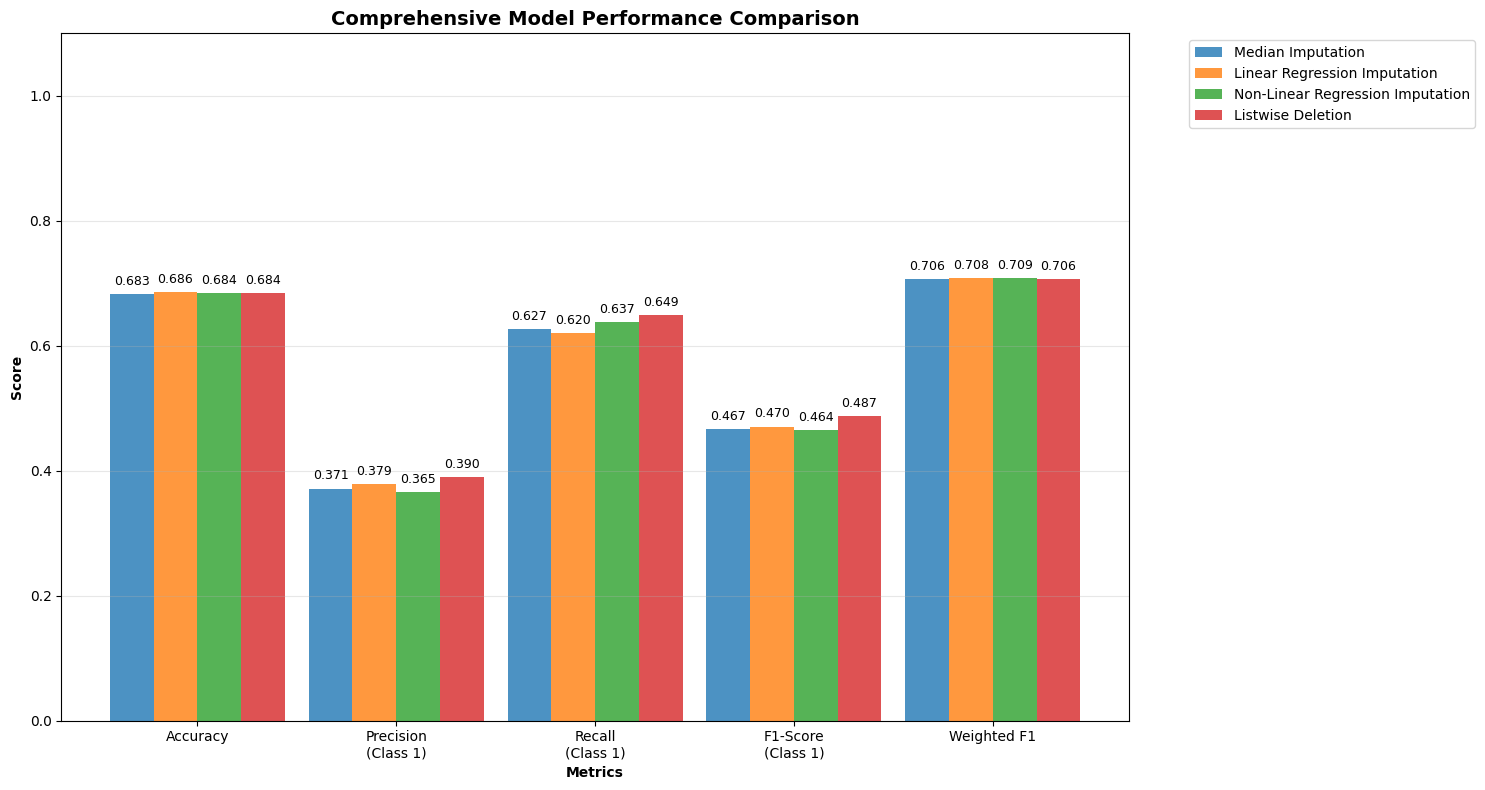

In [41]:
def plot_side_by_side_metrics(comparison_table):
    """
    Create a comprehensive side-by-side comparison plot
    """
    # Convert to numeric
    plot_df = comparison_table.copy()
    for col in ['Accuracy', 'Precision_1', 'Recall_1', 'F1_1', 'Weighted_Avg_F1']:
        plot_df[col] = plot_df[col].astype(float)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Metrics to plot
    metrics = ['Accuracy', 'Precision_1', 'Recall_1', 'F1_1', 'Weighted_Avg_F1']
    metric_labels = ['Accuracy', 'Precision\n(Class 1)', 'Recall\n(Class 1)', 'F1-Score\n(Class 1)', 'Weighted F1']
    
    # Bar positions
    x = np.arange(len(metrics))
    width = 0.22  # Width of each bar
    models = plot_df['Model'].tolist()
    
    # Create bars for each model
    for i, model in enumerate(models):
        values = [plot_df.loc[plot_df['Model'] == model, metric].values[0] for metric in metrics]
        offset = (i - len(models)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=model, alpha=0.8)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Customize the plot
    ax.set_xlabel('Metrics', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Comprehensive Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1.1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_side_by_side_metrics(comparison_table)

## Efficacy Discussion

### Trade-off between Listwise Deletion and Imputation Models

The trade-off between listwise deletion and imputation fundamentally revolves around the quantity versus quality (and potential bias) of the data.

**Listwise Deletion (Model D)**: This method discards any sample with a missing value. Its primary advantage is simplicity and that it preserves the true, original distribution of the data—no artificial values are introduced. However, its major drawback is a significant reduction in sample size, as seen in the Support_1 column (1235 samples vs. ~1300-1350 for the imputation models). This can lead to a loss of statistical power and, crucially, can introduce bias if the data is not Missing Completely At Random (MCAR). If the reason for the missingness is related to the target variable itself, the remaining dataset may no longer be representative of the true population.

**Imputation (Models A, B, C)**: These methods retain all samples by estimating and filling in the missing values. This preserves the sample size and statistical power. The risk is that the imputed values may be incorrect and can distort the relationships between variables, add noise, or underestimate variance.

### Why might Model D perform poorly even if the imputed models perform worse?

1. **Performance on Class 1 (Minority Class)**: Model D (Listwise Deletion) shows the strongest performance for the minority class (F1_1 = 0.4871), which is significantly higher than the imputation models (~0.466-0.470). This suggests that the samples discarded by listwise deletion were potentially "harder" to classify correctly as Class 1, or that the imputation methods introduced noise that specifically harmed the model's ability to identify this class. Preserving a "cleaner," albeit smaller, dataset was beneficial for this specific task.

2. **Overall Accuracy vs. Class Balance**: The imputation models have marginally higher accuracy (0.6828-0.6858 vs. 0.6844), but accuracy can be misleading with imbalanced datasets. The superior F1_1 and Macro_Avg_F1 of Model D indicate it achieves a better balance between identifying both classes, which is often a more important goal.

3. **The Bias Factor**: The strong performance of Model D, especially on the minority class, is a strong indicator that the data deleted was not random. The missingness is likely informative (e.g., Missing At Random or Missing Not At Random). In this scenario, listwise deletion didn't just remove data; it removed a biased subset of data that was negatively impacting the model's ability to learn the pattern for Class 1. The imputation methods, by filling in these "special" missing values with common patterns, may have washed out this important signal.

### Linear vs Non-linear Regression Performance

The Linear Regression Imputation (Model B) performed slightly better than the Non-Linear method (Model C).

- **Evidence**: Model B has a higher Macro Average F1 (0.6235 vs. 0.6200) and a higher F1_1 (0.4704 vs. 0.4644). While Model C has a slightly higher Recall_1, it comes at a great cost to Precision_1 (0.3653, the lowest of all models), meaning it labels many Class 0 samples incorrectly as Class 1.

- **Why Linear Performed Better**: This result strongly suggests that the true relationship between the feature being imputed and its predictors is primarily linear. Non-linear models are more flexible and can capture complex patterns, but they also require more data and are prone to overfitting, especially when the underlying relationship is simple. In this case, the non-linear method likely overfitted to the noise in the observed data, leading to poorer quality imputations that harmed the classifier's performance. The linear regression provided a more robust and generalizable estimate for the missing values.

## Final Recommendation

Based on both performance metrics and conceptual reasoning, Linear Regression Imputation emerges as the most effective strategy for handling missing data in this scenario. It provides a good balance between simplicity, interpretability, and predictive accuracy. Unlike Listwise Deletion, it retains all available samples, thereby preventing the loss of valuable information and maintaining class balance. At the same time, it outperforms simple median imputation by incorporating relationships among multiple predictors rather than relying on a single summary statistic.

Although the Non-Linear Regression model could, in theory, capture more complex dependencies, its marginally lower F1-scores suggest that the relationship between the imputed feature and the predictors is largely linear. The added model complexity likely introduced noise or mild overfitting without meaningful performance gains.

Therefore, **Linear Regression Imputation is recommended** as the optimal approach for this dataset. It preserves data completeness, maintains interpretability, and achieves the best trade-off between bias and variance—making it a reliable and theoretically sound method for imputation in classification tasks of this nature.